# Car price rating

Service for the sale of used cars "Not beaten, not beautiful" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. At your disposal are historical data: technical specifications, equipment and prices of cars. You need to build a model to determine the cost.

The customer is want to see:

- quality of prediction;
- prediction speed;
- studying time.

## Import all necessary

In [57]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

state = 12345
import warnings
warnings.filterwarnings('ignore')

## Data preparation

In [58]:
data_raw = pd.read_csv('autos.csv')
data_raw

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [59]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [60]:
data_raw.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [61]:
data_raw['DateCrawled'].unique()

array(['2016-03-24 11:52:17', '2016-03-24 10:58:45',
       '2016-03-14 12:52:21', ..., '2016-03-21 09:50:58',
       '2016-03-14 17:48:27', '2016-03-19 18:57:12'], dtype=object)

### Consider features and goals for training models

#### Features

- DateCrawled — the date of downloading the questionnaire from the database, this feature does not affect the cost, we will not consider it.
- VehicleType - type of car body, categorical feature, there are gaps.
- RegistrationYear - the year of registration of the car, a quantitative attribute, there are no gaps. There are strange values ​​​​of 1000 and 9999, they will have to be got rid of.
- Gearbox - type of gearbox, categorical feature, there are omissions.
- Power - power (hp), quantitative sign, no gaps. There are strange values ​​of 0, we need to get rid of them.
- Model - car model, categorical feature, there are gaps.
- Kilometer - mileage (km), quantitative sign, no passes.
- RegistrationMonth - the month of registration of the car, a quantitative sign, no passes. There are strange values ​​of 0, we need to get rid of them.
- FuelType — type of fuel, categorical feature, there are gaps.
- Brand — car brand, categorical feature, no gaps.
- Repaired - was the car under repair or not, a categorical sign, the most passes.
- DateCreated — the date the questionnaire was created, this feature does not affect the cost, we will not consider it.
- NumberOfPictures - the number of photos of the car, this attribute does not affect the cost, we will not consider it.
- PostalCode - the postal code of the owner of the profile (user), this feature does not affect the cost, we will not consider it.
- LastSeen - the date of the last user activity, this feature does not affect the cost, we will not consider it.

#### Target

- Price — price (euro), quantity, no omissions. There are strange values of 0, we need to get rid of them.

### Data preprocessing

#### Remove extra columns

In [62]:
data = data_raw.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [63]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


#### Remove empty values

We have empty values (nan) in the columns: VehicleType, Gearbox, Model, FuelType, Repaired. We could delete them, but we will lose a lot of other data, which is bad. Accordingly, it is possible to change empty values to a "stub", for example 'unknown', which in itself will be a value, not a gap, while it will additionally contribute to model training, since a gap in the car sale announcement affects the cost sales.

In [64]:
data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']] = data[['VehicleType', 
                                                                          'Gearbox', 
                                                                          'Model', 
                                                                          'FuelType', 
                                                                          'Repaired']].fillna('unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        354369 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            354369 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              354369 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           354369 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           354369 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


#### Remove suspicious and strange values

Price column

In [65]:
# remove all null values
data = data[data['Price'] > 50].reset_index(drop=True)

RegistrationYear Column

In [66]:
#remove all values that are weirdly above 2022 and weirdly below 1900 because it can't be.
data = data[(data['RegistrationYear'] > 1900) & (data['RegistrationYear'] <= 2026)].reset_index(drop=True)
data.loc[data['RegistrationYear'] >= 2017, 'RegistrationYear'] = data.loc[
                                             data['RegistrationYear'] >= 2017, 'RegistrationYear'] - 10

Power column

<AxesSubplot:xlabel='Power'>

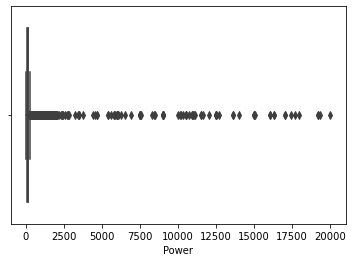

In [67]:
sns.boxplot (x = data['Power'])

There are zero values in the Power column (not nan), and there are also values that are off scale, more than 1000 horsepower, which cannot be. Most likely an error occurred when entering data into the ad. You can divide the "off scale" values by 100, since here the error is clearly related to the fact that someone tried to add hundredths, but did not put a decimal separator.

<AxesSubplot:xlabel='Power'>

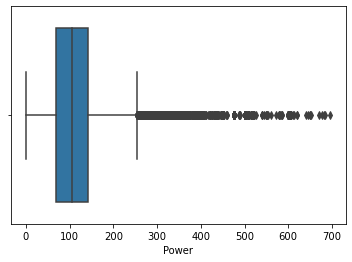

In [68]:
data.loc[data['Power'] >= 700, 'Power'] = data.loc[data['Power'] >= 700, 'Power'] / 100
sns.boxplot (x = data['Power'])

In [69]:
(data['Power'] == 0).sum()

35270

The main part of the machines we have turned out with capacities in the region of 100 hp, which is quite true. Values above 700 are also most likely a mistake, they were also divided by 100, since most city cars start at 70 hp. As for zero values, we will leave them as zeros, since there is nothing to replace them with, and deleting such a large number of values is bad.

RegistrationMonth Column

In [70]:
(data['RegistrationMonth'] == 0).sum()

31818

There are too many values with a zero month of the posted announcement to simply remove them. You can replace the zero month with a random one.

In [71]:
def random_month(row):
    month = row['RegistrationMonth']
    if month == 0:
        return np.random.randint(1, 12)
    else:
        return month
    
data['RegistrationMonth'] = data.apply(random_month, axis=1)

In [72]:
data['RegistrationMonth'].unique()

array([ 7,  5,  8,  6, 10,  4, 12, 11,  2,  3,  1,  9], dtype=int64)

#### Check duplicates

In [73]:
data.duplicated().sum()

24820

Let's try to remove duplicates and see how much data we have left after all the preprocessing steps.

In [74]:
data.drop_duplicates().reset_index(drop=True)
deleted = ((data_raw.shape[0] - data.shape[0]) / data_raw.shape[0]) * 100
print ('After preprocessing we have lost around', round (deleted), '% of data')

After preprocessing we have lost around 4 % of data


### Intermediate output

1. A new dataframe was created so as not to touch the original one.
2. Features for learning and the target feature were considered.
3. "Extra" columns were removed, which could interfere with the training of models.
4. Empty (nan) values have been removed or changed.
5. Strange and suspicious values have been removed or changed.
6. Duplicate lines have been removed.
7. Data loss after all procedures was 4%, which is acceptable.

## Model training

### Highlight features and targets

#### Define categorical and quantitative features into variables

In [75]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
quantitive = ['Power', 'RegistrationYear', 'Kilometer', 'RegistrationMonth']

#### Encode categorical features using the Ordinal Encoding

In [76]:
encoder = OrdinalEncoder()
data[categorical] = pd.DataFrame(encoder.fit_transform(data[categorical]), columns = categorical)


In [77]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,7.0,1993,1.0,0.0,116.0,150000,7,6.0,38.0,1.0
1,18300,2.0,2011,1.0,190.0,228.0,125000,5,2.0,1.0,2.0
2,9800,6.0,2004,0.0,163.0,117.0,125000,8,2.0,14.0,1.0
3,1500,5.0,2001,1.0,75.0,116.0,150000,6,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69.0,101.0,90000,7,2.0,31.0,0.0


#### Divide samples

In [78]:
target = data['Price']
features = data.drop(['Price'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state = state)

Separate the test sample

In [79]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state = state)

#### Scale numerical features

In [80]:
scaler = StandardScaler()
scaler.fit(features_train[quantitive])
features_train[quantitive] = scaler.transform(features_train[quantitive])
features_valid[quantitive] = scaler.transform(features_valid[quantitive])
features_test[quantitive] = scaler.transform(features_test[quantitive])

### Train the LightGBM Model

In [81]:
lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference = lgb_train)

#### First Hyperparameter Option

Parameters for LightGBM

In [82]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'force_col_wise' : True
}

Check the learning time

In [83]:
%%time
lgb_1 = lgb.train(params,
                  lgb_train,
                  num_boost_round = 40,
                  valid_sets = lgb_eval,
                  early_stopping_rounds = 5)

[1]	valid_0's rmse: 4367.52
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 4245.62
[3]	valid_0's rmse: 4104.07
[4]	valid_0's rmse: 3970.69
[5]	valid_0's rmse: 3846.81
[6]	valid_0's rmse: 3730.49
[7]	valid_0's rmse: 3630.74
[8]	valid_0's rmse: 3528.05
[9]	valid_0's rmse: 3430.31
[10]	valid_0's rmse: 3340.3
[11]	valid_0's rmse: 3255.44
[12]	valid_0's rmse: 3177.26
[13]	valid_0's rmse: 3103.48
[14]	valid_0's rmse: 3035.18
[15]	valid_0's rmse: 2970.9
[16]	valid_0's rmse: 2911.59
[17]	valid_0's rmse: 2860
[18]	valid_0's rmse: 2806.52
[19]	valid_0's rmse: 2757.3
[20]	valid_0's rmse: 2711.1
[21]	valid_0's rmse: 2666
[22]	valid_0's rmse: 2623.73
[23]	valid_0's rmse: 2584.17
[24]	valid_0's rmse: 2545.14
[25]	valid_0's rmse: 2510.39
[26]	valid_0's rmse: 2478.25
[27]	valid_0's rmse: 2448.78
[28]	valid_0's rmse: 2419.61
[29]	valid_0's rmse: 2393.07
[30]	valid_0's rmse: 2367.03
[31]	valid_0's rmse: 2343.04
[32]	valid_0's rmse: 2320.36
[33]	valid_0's rmse: 2299.86
[3

Check the prediction time

In [84]:
%%time
target_pred = lgb_1.predict(features_valid, num_iteration = lgb_1.best_iteration)
RMSE_lgb_1 = mean_squared_error(target_valid, target_pred) ** 0.5
print('RMSE для lgb_1:', round (RMSE_lgb_1, 2))

RMSE для lgb_1: 2181.56
CPU times: total: 375 ms
Wall time: 40.9 ms


#### Second hyperparameters option

Change this:
- num_leaves: 40
- max_depth: 10
- min_data_in_leaf: 50

In [85]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 40,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'force_col_wise' : True,
    'max_depth': 10,
    'min_data_in_leaf': 50
}

In [86]:
%%time
lgb_2 = lgb.train(params,
                     lgb_train,
                     num_boost_round = 40,
                     valid_sets = lgb_eval,
                     early_stopping_rounds = 5)

[1]	valid_0's rmse: 4364.81
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 4240.05
[3]	valid_0's rmse: 4095.93
[4]	valid_0's rmse: 3961.78
[5]	valid_0's rmse: 3835.56
[6]	valid_0's rmse: 3717.02
[7]	valid_0's rmse: 3614.67
[8]	valid_0's rmse: 3509.8
[9]	valid_0's rmse: 3410.76
[10]	valid_0's rmse: 3318.06
[11]	valid_0's rmse: 3232.08
[12]	valid_0's rmse: 3151.96
[13]	valid_0's rmse: 3076.72
[14]	valid_0's rmse: 3006.77
[15]	valid_0's rmse: 2941.04
[16]	valid_0's rmse: 2880.31
[17]	valid_0's rmse: 2827.32
[18]	valid_0's rmse: 2772.89
[19]	valid_0's rmse: 2723.19
[20]	valid_0's rmse: 2675.84
[21]	valid_0's rmse: 2630.45
[22]	valid_0's rmse: 2589.14
[23]	valid_0's rmse: 2550.66
[24]	valid_0's rmse: 2512.75
[25]	valid_0's rmse: 2477.21
[26]	valid_0's rmse: 2443.52
[27]	valid_0's rmse: 2412.86
[28]	valid_0's rmse: 2383.43
[29]	valid_0's rmse: 2355.42
[30]	valid_0's rmse: 2330.09
[31]	valid_0's rmse: 2306.83
[32]	valid_0's rmse: 2284.46
[33]	valid_0's rmse: 2

In [87]:
%%time
target_pred = lgb_2.predict(features_valid, num_iteration = lgb_2.best_iteration)
RMSE_lgb_2 = mean_squared_error(target_valid, target_pred) ** 0.5
print('RMSE для lgb_2:', round (RMSE_lgb_2, 2))

RMSE для lgb_2: 2145.41
CPU times: total: 344 ms
Wall time: 42.9 ms


#### Third hyperparameter option

Change this:
- num_leaves: 20
- max_depth: 20
- min_data_in_leaf: 30
- num_iterations: 30

In [88]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'force_col_wise' : True,
    'max_depth': 20,
    'min_data_in_leaf': 30,
    'num_iterations': 30
}

In [89]:
%%time
lgb_3 = lgb.train(params,
                  lgb_train,
                  num_boost_round = 40,
                  valid_sets = lgb_eval,
                  early_stopping_rounds = 5)

[1]	valid_0's rmse: 4373.75
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 4257.88
[3]	valid_0's rmse: 4120.65
[4]	valid_0's rmse: 3993.55
[5]	valid_0's rmse: 3873.12
[6]	valid_0's rmse: 3761.22
[7]	valid_0's rmse: 3667.1
[8]	valid_0's rmse: 3568.43
[9]	valid_0's rmse: 3474.95
[10]	valid_0's rmse: 3387.57
[11]	valid_0's rmse: 3306.34
[12]	valid_0's rmse: 3230.57
[13]	valid_0's rmse: 3159.71
[14]	valid_0's rmse: 3093.8
[15]	valid_0's rmse: 3031.39
[16]	valid_0's rmse: 2973.21
[17]	valid_0's rmse: 2923.36
[18]	valid_0's rmse: 2869.21
[19]	valid_0's rmse: 2818.93
[20]	valid_0's rmse: 2774.02
[21]	valid_0's rmse: 2730
[22]	valid_0's rmse: 2688.35
[23]	valid_0's rmse: 2650.34
[24]	valid_0's rmse: 2616.11
[25]	valid_0's rmse: 2581.19
[26]	valid_0's rmse: 2548.82
[27]	valid_0's rmse: 2519.39
[28]	valid_0's rmse: 2492.03
[29]	valid_0's rmse: 2464.8
[30]	valid_0's rmse: 2439.42
Did not meet early stopping. Best iteration is:
[30]	valid_0's rmse: 2439.42
CPU time

In [90]:
%%time
target_pred = lgb_3.predict(features_valid, num_iteration = lgb_3.best_iteration)
RMSE_lgb_3 = mean_squared_error(target_valid, target_pred) ** 0.5
print('RMSE для lgb_3:', round (RMSE_lgb_3, 2))

RMSE для lgb_3: 2439.42
CPU times: total: 344 ms
Wall time: 39.9 ms


### Train the CatBoost Model

#### First hyperparameter option

Define the model parameters

In [91]:
params = {'iterations': 30, 
          'eval_metric':'RMSE', 
          'verbose': 4,
          'random_seed': 12345
         }

In [92]:
cb_1 = CatBoostRegressor(**params)

Check the training time

In [93]:
%%time
cb_1.fit(features_train, target_train, eval_set = (features_valid, target_valid))

Learning rate set to 0.5
0:	learn: 3252.0661157	test: 3272.3493929	best: 3272.3493929 (0)	total: 13.9ms	remaining: 404ms
4:	learn: 2206.3727073	test: 2220.8161784	best: 2220.8161784 (4)	total: 56.6ms	remaining: 283ms
8:	learn: 2067.6114515	test: 2082.0597955	best: 2082.0597955 (8)	total: 103ms	remaining: 240ms
12:	learn: 1985.6976951	test: 1995.9678956	best: 1995.9678956 (12)	total: 148ms	remaining: 193ms
16:	learn: 1945.0808763	test: 1954.7609689	best: 1954.7609689 (16)	total: 190ms	remaining: 145ms
20:	learn: 1911.4954711	test: 1921.8508895	best: 1921.8508895 (20)	total: 236ms	remaining: 101ms
24:	learn: 1881.3195088	test: 1891.3681700	best: 1891.3681700 (24)	total: 280ms	remaining: 55.9ms
28:	learn: 1857.1665735	test: 1869.9423359	best: 1869.9423359 (28)	total: 327ms	remaining: 11.3ms
29:	learn: 1850.9808753	test: 1864.6987629	best: 1864.6987629 (29)	total: 337ms	remaining: 0us

bestTest = 1864.698763
bestIteration = 29

CPU times: total: 4.14 s
Wall time: 447 ms


Check the prediction time

In [94]:
%%time
target_pred = cb_1.predict(features_valid)
RMSE_сb_1 = mean_squared_error(target_valid, target_pred) ** 0.5
print('RMSE для сb_1:', round (RMSE_сb_1, 2))

RMSE для сb_1: 1864.7
CPU times: total: 0 ns
Wall time: 7.98 ms


#### Second hyperparameter option

Change this:
- iterations: 50
- learning_rate: 0.05
- use_best_model: True

In [95]:
params = {'iterations': 50, 
          'eval_metric':'RMSE', 
          'verbose': 4,
          'random_seed': 12345,
          'learning_rate': 0.05,
          'use_best_model': True
         }

In [96]:
cb_2 = CatBoostRegressor(**params)

In [97]:
%%time
cb_2.fit(features_train, target_train, eval_set = (features_valid, target_valid))

0:	learn: 4369.3972286	test: 4382.8418889	best: 4382.8418889 (0)	total: 12.8ms	remaining: 629ms
4:	learn: 3882.0672681	test: 3897.1271307	best: 3897.1271307 (4)	total: 59.1ms	remaining: 532ms
8:	learn: 3498.9625789	test: 3516.1055648	best: 3516.1055648 (8)	total: 106ms	remaining: 482ms
12:	learn: 3195.4641922	test: 3214.9467970	best: 3214.9467970 (12)	total: 150ms	remaining: 427ms
16:	learn: 2964.0478900	test: 2984.3404498	best: 2984.3404498 (16)	total: 194ms	remaining: 376ms
20:	learn: 2785.6828084	test: 2806.5137505	best: 2806.5137505 (20)	total: 241ms	remaining: 333ms
24:	learn: 2643.6713064	test: 2664.2402512	best: 2664.2402512 (24)	total: 284ms	remaining: 284ms
28:	learn: 2532.5025100	test: 2552.4071560	best: 2552.4071560 (28)	total: 331ms	remaining: 240ms
32:	learn: 2447.9620912	test: 2467.4194499	best: 2467.4194499 (32)	total: 374ms	remaining: 193ms
36:	learn: 2377.5729613	test: 2396.6861173	best: 2396.6861173 (36)	total: 418ms	remaining: 147ms
40:	learn: 2321.8034085	test: 2340

In [98]:
%%time
target_pred = cb_2.predict(features_valid)
RMSE_сb_2 = mean_squared_error(target_valid, target_pred) ** 0.5
print('RMSE для сb_2:', round (RMSE_сb_2, 2))

RMSE для сb_2: 2244.1
CPU times: total: 93.8 ms
Wall time: 9.98 ms


#### Third hyperparameter option

Change this:
- iterations: 100
- learning_rate: 0.02
- bagging_temperature: 0.2 
- depth: 12
- od_type: 'Iter'
- od_wait: 100

In [99]:
params = {'iterations': 100, 
          'eval_metric':'RMSE', 
          'verbose': 7,
          'random_seed': 12345,
          'learning_rate': 0.02,
          'use_best_model': True,
          'bagging_temperature': 0.2,
          'depth': 12,
          'od_type': 'Iter',
          'od_wait': 100
         }

In [100]:
cb_3 = CatBoostRegressor(**params)

In [101]:
%%time
cb_3.fit(features_train, target_train, eval_set = (features_valid, target_valid))

0:	learn: 4448.1679866	test: 4461.0976815	best: 4461.0976815 (0)	total: 63.3ms	remaining: 6.26s
7:	learn: 4040.8518966	test: 4055.9684263	best: 4055.9684263 (7)	total: 496ms	remaining: 5.7s
14:	learn: 3691.6029872	test: 3708.5541046	best: 3708.5541046 (14)	total: 936ms	remaining: 5.3s
21:	learn: 3396.7675139	test: 3415.6387278	best: 3415.6387278 (21)	total: 1.36s	remaining: 4.83s
28:	learn: 3147.5220141	test: 3167.5986041	best: 3167.5986041 (28)	total: 1.78s	remaining: 4.35s
35:	learn: 2937.5896948	test: 2959.7606332	best: 2959.7606332 (35)	total: 2.21s	remaining: 3.92s
42:	learn: 2762.6094552	test: 2785.7334124	best: 2785.7334124 (42)	total: 2.62s	remaining: 3.48s
49:	learn: 2615.5638243	test: 2639.7578717	best: 2639.7578717 (49)	total: 3.04s	remaining: 3.04s
56:	learn: 2492.1130590	test: 2517.4435720	best: 2517.4435720 (56)	total: 3.46s	remaining: 2.61s
63:	learn: 2388.3679104	test: 2415.1676725	best: 2415.1676725 (63)	total: 3.88s	remaining: 2.19s
70:	learn: 2303.0328984	test: 2330.

In [102]:
%%time
target_pred = cb_3.predict(features_valid)
RMSE_сb_3 = mean_squared_error(target_valid, target_pred) ** 0.5
print('RMSE для сb_3:', round (RMSE_сb_3, 2))

RMSE для сb_3: 2090.31
CPU times: total: 172 ms
Wall time: 25.9 ms


### Train the RandomForestRegressor Model

#### Select hyperparameters of the random forest

In [103]:
best_result_est = 3000
best_depth = 0
best_est = 0

for est in range(1, 5):
    for depth in range(1, 5):
        model = RandomForestRegressor(random_state = state, n_estimators = est, max_depth = depth)
        model.fit(features_train, target_train)
        target_pred = model.predict(features_valid)
        result = (mean_squared_error(target_valid, target_pred) ** 0.5)

        if result < best_result_est:
            best_result_est = result
            best_depth = depth
            best_est = est

print('best_depth:', best_depth)
print('best_est:', best_est)


best_depth: 4
best_est: 4


#### Check the time and metric on a random forest

Check the train time

In [104]:
%%time
model = RandomForestRegressor(random_state = state, n_estimators = 4, max_depth = 4)
model.fit(features_train, target_train)

CPU times: total: 500 ms
Wall time: 467 ms


RandomForestRegressor(max_depth=4, n_estimators=4, random_state=12345)

Check the prediction time

In [105]:
%%time
target_pred = model.predict(features_valid)
RMSE_RFR = mean_squared_error(target_valid, target_pred) ** 0.5
print('RMSE для RFR:', round (RMSE_RFR, 2))

RMSE для RFR: 2641.69
CPU times: total: 15.6 ms
Wall time: 15.5 ms


## Model compairing

|Модель  |RMSE | Время обучения, s | Время предсказания, ms  |
| -------|--------------------|----------------|---------------------|
| LightGBM 1 |2181.56 | 6.84|119|
| LightGBM 2 |2145.41 | 6.05|218|
| LightGBM 3 |2439.42| 23.3|87.7|
|**CatBoost 1**|**1862.28**|**1.68**|**10.1**|
| CatBoost 2 |2244.10|2.18|10.7|
| CatBoost 3 |2090.31|10.4|66.6|
|RandomForestRegressor| 2641.69|9.88|16.9

## Model choice

### Choose the best model

According to the study results, the best model for this study is CatBoost, as it has the highest learning rate, the highest prediction rate, and the lowest value of the RMSE metric.

Let's test the model on a test set.

In [106]:
params = {'iterations': 30, 
          'eval_metric':'RMSE', 
          'verbose': 4,
          'random_seed': 12345
         }

cb = CatBoostRegressor(**params)

cb.fit(features_train, target_train, eval_set = (features_valid, target_valid))

Learning rate set to 0.5
0:	learn: 3252.0661157	test: 3272.3493929	best: 3272.3493929 (0)	total: 12.1ms	remaining: 351ms
4:	learn: 2206.3727073	test: 2220.8161784	best: 2220.8161784 (4)	total: 57.9ms	remaining: 289ms
8:	learn: 2067.6114515	test: 2082.0597955	best: 2082.0597955 (8)	total: 101ms	remaining: 237ms
12:	learn: 1985.6976951	test: 1995.9678956	best: 1995.9678956 (12)	total: 149ms	remaining: 194ms
16:	learn: 1945.0808763	test: 1954.7609689	best: 1954.7609689 (16)	total: 192ms	remaining: 146ms
20:	learn: 1911.4954711	test: 1921.8508895	best: 1921.8508895 (20)	total: 239ms	remaining: 103ms
24:	learn: 1881.3195088	test: 1891.3681700	best: 1891.3681700 (24)	total: 285ms	remaining: 57ms
28:	learn: 1857.1665735	test: 1869.9423359	best: 1869.9423359 (28)	total: 333ms	remaining: 11.5ms
29:	learn: 1850.9808753	test: 1864.6987629	best: 1864.6987629 (29)	total: 344ms	remaining: 0us

bestTest = 1864.698763
bestIteration = 29



In [107]:
%%time
target_pred = cb.predict(features_test)
RMSE_сb = mean_squared_error(target_test, target_pred) ** 0.5
print('RMSE для сb:', round (RMSE_сb, 2))

RMSE для сb: 1882.17
CPU times: total: 0 ns
Wall time: 8.98 ms


- RMSE of the selected model on the test sample - 1882.17
- Training time on a non-test sample - 8.98 ms

### Consider the importance of features

Decompose the signs according to the degree of influence on the price of the car

In [108]:
params = {'iterations': 30, 
          'eval_metric':'RMSE', 
          'verbose': 4,
          'random_seed': 12345
         }

cb = CatBoostRegressor(**params)

cb.fit(features_train, target_train, eval_set = (features_valid, target_valid))

importance = model.feature_importances_  
feature_list = list(features_train.columns)  
feature_results = pd.DataFrame({'feature': feature_list,'importance': importance})  
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)  
feature_results

Learning rate set to 0.5
0:	learn: 3252.0661157	test: 3272.3493929	best: 3272.3493929 (0)	total: 11.9ms	remaining: 346ms
4:	learn: 2206.3727073	test: 2220.8161784	best: 2220.8161784 (4)	total: 55.5ms	remaining: 277ms
8:	learn: 2067.6114515	test: 2082.0597955	best: 2082.0597955 (8)	total: 97ms	remaining: 226ms
12:	learn: 1985.6976951	test: 1995.9678956	best: 1995.9678956 (12)	total: 140ms	remaining: 183ms
16:	learn: 1945.0808763	test: 1954.7609689	best: 1954.7609689 (16)	total: 180ms	remaining: 138ms
20:	learn: 1911.4954711	test: 1921.8508895	best: 1921.8508895 (20)	total: 222ms	remaining: 95.1ms
24:	learn: 1881.3195088	test: 1891.3681700	best: 1891.3681700 (24)	total: 263ms	remaining: 52.7ms
28:	learn: 1857.1665735	test: 1869.9423359	best: 1869.9423359 (28)	total: 306ms	remaining: 10.5ms
29:	learn: 1850.9808753	test: 1864.6987629	best: 1864.6987629 (29)	total: 316ms	remaining: 0us

bestTest = 1864.698763
bestIteration = 29



,feature,importance
0,RegistrationYear,0.585054
1,Power,0.355481
2,Kilometer,0.049931
3,FuelType,0.006909
4,VehicleType,0.002625
5,Gearbox,0.000000
6,Model,0.000000
7,RegistrationMonth,0.000000
8,Brand,0.000000
9,Repaired,0.000000


Graph of the importance of features

<Figure size 432x288 with 0 Axes>

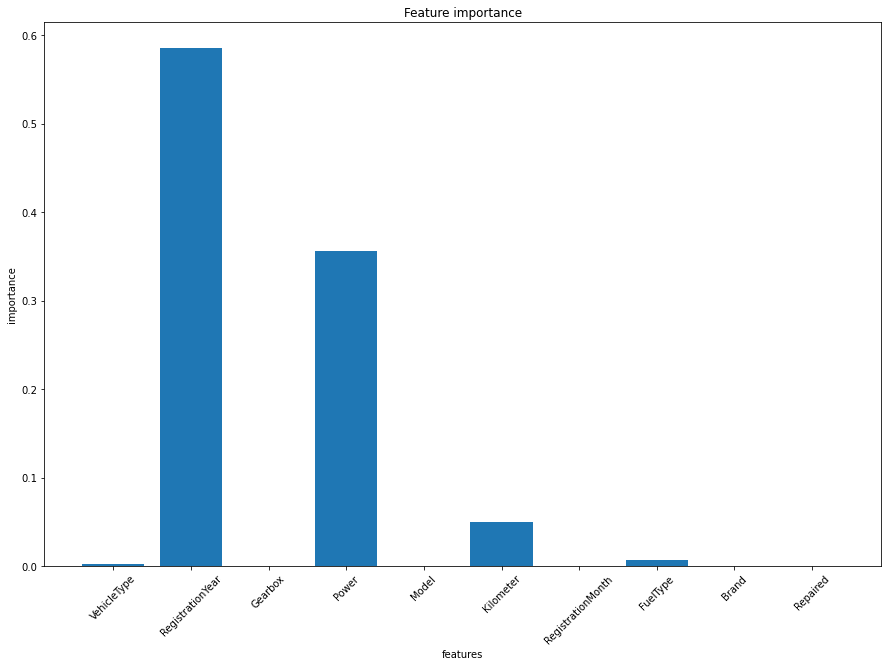

In [109]:
plt.figure()
plt.figure(figsize=(15,10))
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(np.arange(10),feature_list, rotation=45)
plt.show()

The main features that affect the value of a car are:
- Year of issue.
- Vehicle power.
- Car mileage.

## General conclusion

1. Data is open and explored.
2. Data pre-processing was carried out, no more than 4% of data was lost.
3. The goals and signs of learning are highlighted.
4. The model with gradient boosting LightGBM was trained.
5. The model was trained with CatBoost gradient boosting.
6. The model was trained without RandomForestRegressor gradient boosting.
7. The speed of work and the quality of the models are tabulated.
8. The model with the highest speed and the highest quality of predictions was selected.
9. The selected model was tested on a test sample, the results were recognized as excellent.
10. It was found that the main features that affect the cost are the year of manufacture, power and mileage of the car.